# Evaluating a Pre-trained Model for Semantic Search (Retrieval)
**Author:** Wei Wang

- **Dataset:** ESCI Shopping Queries Data Set (Reduced Version / Full Version) ([GitHub link](https://github.com/amazon-science/esci-data))
- **Model:** all-MiniLM-L6-v2 ([Hugging Face link](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2))
- **Task:** Evaluate model performance directly on the dataset without fine-tuning.
- **Metric:** NDCG@10, recall@10 and MRR@10.

---

## Import libraries

In [17]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

# Local application/library specific imports
from src.data_loader import DataLoader
from src.data_preprocessor import DataPreprocessor
from src.model_evaluator import ModelEvaluator

## Dataset Overview

### ESCI Data

The **Shopping Queries Data Set** ([GitHub link](https://github.com/amazon-science/esci-data)) is a large-scale, manually annotated collection of challenging search queries, designed to support research in semantic matching between queries and products.

For each query, the dataset includes up to 40 potentially relevant products, each annotated with an ESCI relevance judgment:

- **Exact match (E)**
- **Substitute (S)**
- **Complement (C)**
- **Irrelevant (I)**

These labels indicate how well each product aligns with the query. Each query-product pair is also accompanied by additional contextual information.  
The dataset is **multilingual**, featuring queries in **English (us)**, **Japanese (jp)**, and **Spanish (es)**.

---

#### Full Dataset

- **130,652** unique queries
- **2,621,738** query-item pairs
- Provides a broad and comprehensive set of examples for extensive training and evaluation

#### Reduced Version (Provided by the Authors)

- **48,300** unique queries
- **1,118,011** query-item pairs
- Focuses on more challenging queries, with "easy" queries filtered out

The dataset is stratified by queries into **train** and **test** splits initially.

---

### Data Fields

Each entry in the dataset contains the following fields:

`example_id`, `query`, `query_id`, `product_id`, `product_locale`, `esci_label`, `small_version`, `large_version`, `split`, `product_title`, `product_description`, `product_bullet_point`, `product_brand`, `product_color`, `source`

### Columns Used for This Task

For the purposes of this task, we focus on the following columns:

- `query`
- `product_title`
- `product_description`
- `product_locale`
- `small_version`
- `large_version`
- `split`
- `esci_label`

These fields provide the essential information needed for training and evaluating semantic search models, combining textual content from queries and products with structured relevance labels for supervised learning.

---

In [2]:
# Take a look at the ESCI dataset
loaded_data = DataLoader(
        example_path="dataset/shopping_queries_dataset_examples.parquet",
        products_path="dataset/shopping_queries_dataset_products.parquet",
        small_version=True, # Load a small version of the dataset for data exploration
    )
loaded_data.load_data()
loaded_data.df.head(5)

,query,title,description,relevance,split,product_locale
16,!awnmower tires without rims,"RamPro 10"" All Purpose Utility Air Tires/Wheel...","<b>About The Ram-Pro All Purpose Utility 10"" A...",1,train,us
17,!awnmower tires without rims,MaxAuto 2-Pack 13x5.00-6 2PLY Turf Mower Tract...,MaxAuto 2-Pack 13x5.00-6 2PLY Turf Mower Tract...,4,train,us
18,!awnmower tires without rims,NEIKO 20601A 14.5 inch Steel Tire Spoon Lever ...,None,1,train,us
19,!awnmower tires without rims,2PK 13x5.00-6 13x5.00x6 13x5x6 13x5-6 2PLY Tur...,"Tire Size: 13 x 5.00 - 6 Axle: 3/4"" inside dia...",3,train,us
20,!awnmower tires without rims,(Set of 2) 15x6.00-6 Husqvarna/Poulan Tire Whe...,No fuss. Just take off your old assembly and r...,4,train,us


### Data Preprocessing

In preparation for semantic search and product retrieval tasks, I performed a comprehensive data cleaning process on the **Shopping Queries Data Set**. This was necessary to ensure that the input text is clean, meaningful, and suitable for downstream modeling.

---

#### Key Data Cleaning Steps

##### 1. Removal of HTML Tags and Special Characters

Upon inspecting the extracted vocabulary, it became clear that a significant portion of the words were HTML tags rather than meaningful content. These tags introduce noise into both bag-of-words models and semantic search embeddings.

To address this, I systematically removed all HTML tags from the following text fields:
- **query**
- **product_title**
- **product_description**

For English-language (`us`) data, I further cleaned the text by removing special characters and symbols that do not contribute to the semantic meaning of the text. This included punctuation marks, brackets, and other non-alphanumeric characters, while preserving spaces to maintain word boundaries.

This ensured that only the true textual content was retained for model training and evaluation.

##### 2. Drop NULL Value
Drop rows where any of the following columns are NULL:
- **query**
- **product_title**

I have excluded **product_description** since in general cases, description is considered optional, while query and product_title are essential for search and matching.

##### 3. Conversion of ESCI Labels to Digits

To facilitate model training and evaluation, the categorical ESCI labels were mapped to numerical values.  
This conversion allows relevance judgments to be handled easily in classification tasks or scoring models.

The mapping is as follows:

- **E (Exact match)** → **4**
- **S (Substitute)** → **3**
- **C (Complement)** → **2**
- **I (Irrelevant)** → **1**

By converting the labels to integers, it becomes possible to apply standard machine learning algorithms that require numerical targets, and to compute ranking metrics (such as NDCG) in a straightforward way.


##### 4. Text Normalization

As part of the cleaning process:
- All text was converted to **lowercase** to ensure case-insensitive matching.
- Tokenization steps (for bag-of-words analysis) were performed on clean, normalized text.



##### 5. Locale Filtering

Since the dataset is multilingual (English, Japanese, Spanish), I filtered the data to focus only on the desired locale (e.g., English `"us"`) when necessary.  
Different languages may result different evluation results.



##### 6. Creation of Combined Text Field

Since the task is not asking for fine tuning, I created a new field, **`combined_text`**, by concatenating the cleaned `product_title` and `product_description`.  
This allowed the models to leverage richer product information and better capture the full semantic context during model evluation.




In [7]:
# Run preprocessing on the loaded data
data_preprocessor = DataPreprocessor(loaded_data.df,language="us")
data_preprocessor.get_bag_of_words()

,word,frequency
50,la,436415
67,para,413736
32,el,328227
33,en,265231
82,size,181138
...,...,...
47,just,44680
29,designed,44213
30,durable,44024
78,red,43413


In [8]:
# Clean the data
data_preprocessor.data_preprocessing()

In [12]:
# Take a look at the cleaned data stats
print("Data stats after preprocessing:")
data_preprocessor.get_dataset_stats()

Data stats after preprocessing:


{'total_samples': 1118011,
 'unique_queries': 48241,
 'avg_products_per_query': 23.175535333015485,
 'relevance_distribution': {1: 0.16764235772277733,
  2: 0.05150396552448947,
  3: 0.343023458624289,
  4: 0.4378302181284442},
 'locale_distribution': {'us': 0.5378784287453343,
  'jp': 0.26644013341550304,
  'es': 0.1956814378391626}}

In [14]:
# Cleaned data sample
print("Sample of cleaned data:")
data_preprocessor.df.head(5)

Sample of cleaned data:


,query,title,description,relevance,split,product_locale,combined_text
16,awnmower tires without rims,rampro 10 all purpose utility air tires wheel...,about the ram pro all purpose utility 10 air ...,1,train,us,rampro 10 all purpose utility air tires wheel...
17,awnmower tires without rims,maxauto 2 pack 13x5 00 6 2ply turf mower tract...,maxauto 2 pack 13x5 00 6 2ply turf mower tract...,4,train,us,maxauto 2 pack 13x5 00 6 2ply turf mower tract...
18,awnmower tires without rims,neiko 20601a 14 5 inch steel tire spoon lever ...,,1,train,us,neiko 20601a 14 5 inch steel tire spoon lever ...
19,awnmower tires without rims,2pk 13x5 00 6 13x5 00x6 13x5x6 13x5 6 2ply tur...,tire size 13 x 5 00 6 axle 3 4 inside dia...,3,train,us,2pk 13x5 00 6 13x5 00x6 13x5x6 13x5 6 2ply tur...
20,awnmower tires without rims,set of 2 15x6 00 6 husqvarna poulan tire whe...,no fuss just take off your old assembly and r...,4,train,us,set of 2 15x6 00 6 husqvarna poulan tire whe...


## Model Selection

### Model Selection: all-MiniLM-L6-v2

For this semantic search task, I selected the **all-MiniLM-L6-v2** model from the Sentence Transformers library.  

---

This decision was based on several key factors:

- **Lightweight and Efficient:**  
  all-MiniLM-L6-v2 maps sentences and paragraphs into a 384-dimensional dense vector space, making it highly efficient in terms of both computation and memory usage compared to larger models like BERT or RoBERTa.

- **Optimized for Semantic Search:**  
  The model has been specifically fine-tuned for semantic textual similarity tasks, making it a strong candidate for retrieval tasks where capturing the true meaning of queries and product descriptions is critical.

- **Performance vs. Speed Trade-off:**  
  It strikes a good balance between retrieval accuracy and inference speed, making it suitable for large-scale product search where latency can be a concern.
  
  From [SBERT.net](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html): The **all-mpnet-base-v2** model provides the best quality, while **all-MiniLM-L6-v2** is 5 times faster and still offers good quality.

- **Multilingual Capabilities:**  
  Although primarily trained on English, all-MiniLM-L6-v2 demonstrates reasonable generalization across multiple languages.  
  Given that the ESCI Data Set includes English, Japanese, and Spanish queries, selecting a model capable of handling multilingual input was essential for broad evaluation coverage.

- **Pre-trained Quality:**  
  Pre-trained on a large and diverse corpus of sentence pairs, all-MiniLM-L6-v2 offers robust out-of-the-box performance without the need for extensive additional fine-tuning.

- **Community Adoption and Benchmarks:**  
  It is widely adopted in industry and research for search, clustering, and question-answering tasks, with consistently strong performance in standard semantic similarity benchmarks.

Given these advantages, **all-MiniLM-L6-v2** was a practical and powerful choice.

The following table provides an overview of a selection of sentence transformer models.

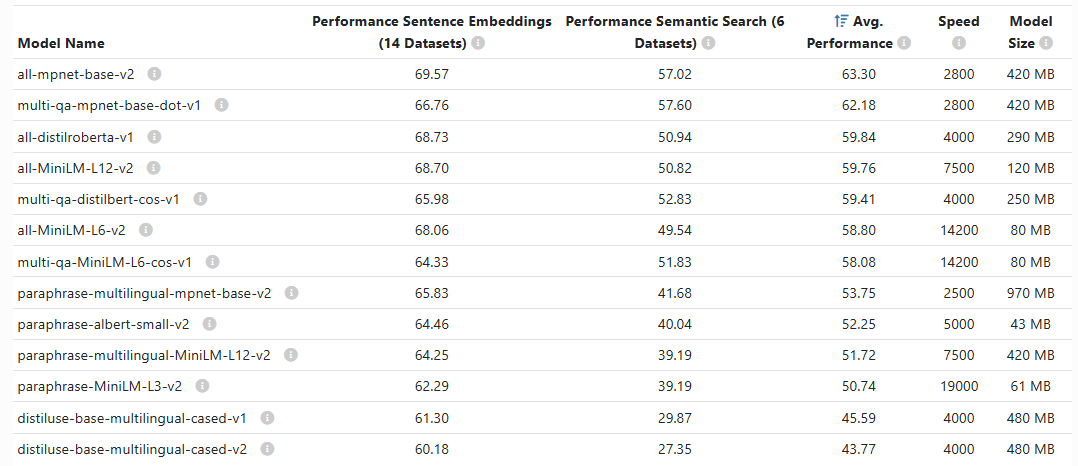

## Model Evaluation

### Model Evaluation Summary

**all-MiniLM-L6-v2** model was evaluated for semantic retrieval across different dataset sizes and language subsets of the ESCI data set (results are shown above the markdown). The results demonstrate strong performance across all settings.

---

#### Key Observations

- **Reduced (Small) Dataset (All Languages):**
  - Achieved a **Test NDCG@10** of **0.903** and **Test MRR@10** of **0.915**.
  - Required significantly less time (~20 minutes).
  - Performance remained high despite using fewer queries and samples.

- **Reduced (Small) Dataset (English Locale "us" Only):**
  - Achieved the highest **Test NDCG@10** (**0.907**) and **Test MRR@10** (**0.924**) among the small dataset evaluations.
  - Recall@10 also improved (**0.603**), suggesting stronger top-10 retrieval accuracy when focusing only on English queries.
  - Processing time was the fastest (~12 minutes).

- **Full Dataset (All Languages):**
  - Achieved a very high **Test NDCG@10** of **0.948** and **Test MRR@10** of **0.957**.
  - Total training and evaluation time was approximately **2909 seconds** (~48 minutes).
  - The model maintained strong retrieval quality even on the large-scale dataset (2.6M samples).

- **Full Dataset (English Locale "us" Only):**
  - Achieved the best overall performance with a **Test NDCG@10** of **0.956** and a **Test MRR@10** of **0.966**.
  - Recall@10 reached **0.614**, the highest across all settings.
  - Processing time was approximately 34 minutes.
  - Indicates that limiting to English ("us" locale) helps the model achieve even stronger semantic matching results.

---

#### Summary

Overall, the **all-MiniLM-L6-v2** model demonstrated excellent performance for semantic retrieval on both full and reduced versions of the dataset, with minimal loss in effectiveness when using smaller subsets.  
Filtering to English queries ("us" locale) slightly improved retrieval accuracy, indicating that the model handles English data slightly better compared to multilingual data.

Given its strong NDCG, Recall, and MRR scores, combined with efficient processing times, **all-MiniLM-L6-v2** is confirmed to be a highly suitable baseline model for this semantic search task.

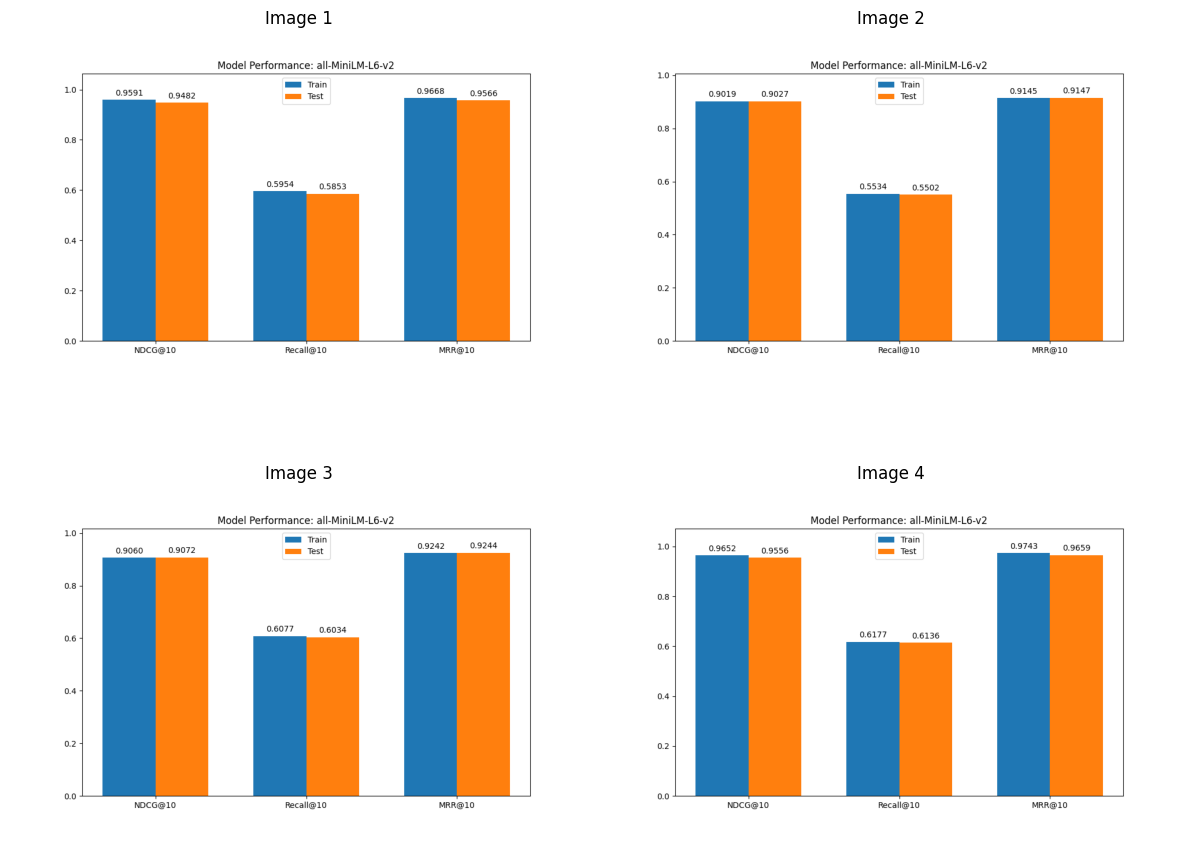

In [22]:
# List of image paths
image_paths = [
    "output/all-MiniLM-L6-v2_all_large_metrics.png",
    "output/all-MiniLM-L6-v2_all_small_metrics.png",
    "output/all-MiniLM-L6-v2_us_metrics.png",
    "output/all-MiniLM-L6-v2_us_large_metrics.png"
]

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# Load and display each image
for i, image_path in enumerate(image_paths):
    img = Image.open(image_path)
    axes[i].imshow(np.array(img))
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')  # Turn off axis numbers

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [29]:
# load all the evluation results
all_small_result = pd.read_csv("output/all-MiniLM-L6-v2_all_small_results.csv")
us_large_result = pd.read_csv("output/all-MiniLM-L6-v2_us_results.csv")
all_large_result = pd.read_csv("output/all-MiniLM-L6-v2_all_large_results.csv")
us_small_result = pd.read_csv("output/all-MiniLM-L6-v2_us_large_results.csv")

# Concatenate the results into a single DataFrame
pd.concat([
    pd.concat([all_small_result,us_large_result], axis=0),
    pd.concat([all_large_result, us_small_result], axis=0)
], axis=0)

,Model,Language,Dataset Size,Total Samples,Unique Queries,Train NDCG@10,Train Recall@10,Train MRR@10,Test NDCG@10,Test Recall@10,Test MRR@10,Total Time (s)
0,all-MiniLM-L6-v2,all,Small,1118011,48249,0.901888,0.553400,0.914473,0.902666,0.550226,0.914748,1224.737690
0,all-MiniLM-L6-v2,us,Small,601354,29842,0.906032,0.607698,0.924167,0.907209,0.603394,0.924425,714.675498
0,all-MiniLM-L6-v2,all,Full,2621288,130192,0.959141,0.595357,0.966769,0.948193,0.585328,0.956551,2909.921573
0,all-MiniLM-L6-v2,us,Full,1818825,97307,0.965228,0.617667,0.974264,0.955629,0.613597,0.965890,2034.235283


## Limitation and Future Steps

### Limitations

While the evaluation of the **all-MiniLM-L6-v2** model showed strong semantic retrieval performance, several limitations remain:

---
#### 1. Multilingual Coverage

The model was primarily pre-trained on English data.  
Although it handled multilingual queries (Japanese, Spanish) reasonably well, its effectiveness across non-English queries was not separately analyzed. Performance gaps across languages may exist.

#### 2. Low Recall@10
While the model achieved high NDCG@10 and MRR@10 scores, the Recall@10 values were comparatively lower.  
This suggests that although the model ranks the most relevant items highly, it does not retrieve all possible relevant products within the top-10 results.

This behavior can be attributed to several factors:
- The inherent label imbalance in the Shopping Queries Data Set, where many products are irrelevant to a query.
- The absence of fine-tuning specific to the ESCI relevance labels (Exact, Substitute, Complement), leading to less precise coverage.
- The strict evaluation at only top-10, which can penalize retrieval models that spread relevant results slightly lower in the ranked list (e.g., 11th or 12th position).

#### 3. Computational Cost

Although **all-MiniLM-L6-v2** is lightweight compared to larger transformer models, full dataset evaluation — especially for multilingual settings — still required significant computational time and resources.

Initially, running on CPU for the small English (us) test dataset took more than one hour, which is inefficient for practical experiments.  
To achieve reasonable inference speed, the evaluation process required access to a GPU.  

#### 4. Dataset Quality and Language Consistency

Although the dataset is labeled with a specific locale, such as **"us"** for English, it was observed that some entries still contain queries written in different languages.  
This inconsistency introduces noise into model evaluation, as language mismatches can confuse semantic retrieval models that expect consistent language patterns.

In particular, the presence of non-English queries or product descriptions within the English ("us") subset may slightly degrade retrieval performance and affect the reliability of evaluation metrics. 


In [35]:
# Limitation number 4: The dataset is not cleaned properly in terms of language filtering
loaded_data.df[loaded_data.df['query']=='香奈儿']

,query,title,description,relevance,split,product_locale,combined_text
2614578,香奈儿,crystal ball photography crystal ball inspir...,,4,test,us,crystal ball photography crystal ball inspir...
2614579,香奈儿,chanel la mousse anti pollution cleansing crea...,chanel la mousse anti pollution cleansing crea...,4,test,us,chanel la mousse anti pollution cleansing crea...
2614580,香奈儿,lip smacker lippy pal lip balm unicorn magic ...,,1,test,us,lip smacker lippy pal lip balm unicorn magic ...
2614581,香奈儿,power full plump lip balm big o 0 17 oz,,1,test,us,power full plump lip balm big o 0 17 oz
2614582,香奈儿,winky lux flower balm color changing flower j...,natural clear lip gloss pack waterproof nude ...,4,test,us,winky lux flower balm color changing flower j...
2614583,香奈儿,chanel no 5 eau premiere spray 50ml 1 7oz,launch year 2007 the nose behind this fragra...,4,test,us,chanel no 5 eau premiere spray 50ml 1 7oz laun...
2614584,香奈儿,burt s bees lip balm stocking stuffer moistur...,,4,test,us,burt s bees lip balm stocking stuffer moistur...
2614585,香奈儿,c h a n e l no 5 edp spray for women 3 4 oz 10...,3 4 oz eau de parfum full sized bottle,4,test,us,c h a n e l no 5 edp spray for women 3 4 oz 10...
2614586,香奈儿,chânél chance eau tendre eau de toilette women...,chance 1 7 fl oz eau de toilette,4,test,us,chânél chance eau tendre eau de toilette women...
2614587,香奈儿,steve madden designer 15 inch carry on suitcas...,make the most out of your next trip with our t...,4,test,us,steve madden designer 15 inch carry on suitcas...


### Future Steps

The following future steps are proposed to further improve model performance, evaluation reliability, and system efficiency:

---

#### 1. Evaluate and Optimize Multilingual Performance

- Conduct separate evaluations for Japanese and Spanish queries to better understand the model’s multilingual capabilities.
- Explore fine-tuning multilingual models (e.g., LaBSE, multilingual MiniLM) or training language-specific models for improved cross-lingual retrieval.

#### 2. Fine-Tune the Model on ESCI Data

- Fine-tune the **all-MiniLM-L6-v2** model on the ESCI to adapt it specifically to the task of semantic product retrieval.
- Fine-tuning can help the model better understand the fine-grained distinctions between Exact, Substitute, Complement, and Irrelevant labels.
- Expected improvements include higher Recall@10, better NDCG@10 scores, and more accurate semantic matching for domain-specific queries.

#### 3. Optimize Computational Efficiency

- Continue utilizing GPUs for faster inference and evaluation.
- Explore efficient retrieval libraries (e.g., **FAISS**) to further reduce computational time and memory usage.

#### 4. Use More Models for Comparison

- Benchmark additional pre-trained sentence embedding models such as **all-mpnet-base-v2**, **multi-qa-mpnet-base-dot-v1**, **paraphrase-multilingual-MiniLM-L12-v2**, and **mpnet-base**.
- Compare performance across different architectures to identify models that might offer better recall, multilingual handling, or efficiency for this specific retrieval task.
- Analyze trade-offs between model size, computational cost, and retrieval accuracy to inform model selection for future production systems.